# Titanic Prediction

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mplt
import matplotlib.pyplot as plt
from  matplotlib.ticker import PercentFormatter

%matplotlib inline
import seaborn as sns

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report

In [2]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
print("Dimensions of train: {}".format(train.shape))
print("Dimensions of test: {}".format(test.shape))

Dimensions of train: (891, 12)
Dimensions of test: (418, 11)


In [3]:
# Store PassengerId
passengerId = test.PassengerId


# drop unnecessary columns, these columns won't be useful in analysis and prediction
train = train.drop(['PassengerId','Ticket'], axis=1)
test = test.drop(['PassengerId','Ticket'], axis=1)
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(4)
memory usage: 29.5+ KB
None


### Computing Missing Values

In [4]:
# create a new feature to extract title names from the Name column
train['Title'] = train.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
test['Title'] = test.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
train['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [5]:
# normalize the titles
normalized_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"
}

# map the normalized titles to the current titles 
train.Title = train.Title.map(normalized_titles)
test.Title = test.Title.map(normalized_titles)

# view value counts for the normalized titles
print(train.Title.value_counts())

Mr         517
Miss       184
Mrs        127
Master      40
Officer     18
Royalty      5
Name: Title, dtype: int64


In [6]:
# group by Sex, Pclass, and Title 
grouped_train = train.groupby(['Sex','Pclass', 'Title'])  
grouped_test = test.groupby(['Sex','Pclass', 'Title'])  

# view the median Age by the grouped features 
grouped_train.Age.median()

Sex     Pclass  Title  
female  1       Miss       30.0
                Mrs        40.0
                Officer    49.0
                Royalty    40.5
        2       Miss       24.0
                Mrs        31.5
        3       Miss       18.0
                Mrs        31.0
male    1       Master      4.0
                Mr         40.0
                Officer    51.0
                Royalty    40.0
        2       Master      1.0
                Mr         31.0
                Officer    46.5
        3       Master      4.0
                Mr         26.0
Name: Age, dtype: float64

In [7]:
# apply the grouped median value on the Age NaN
train.Age = grouped_train.Age.apply(lambda x: x.fillna(x.median()))
test.Age = grouped_test.Age.apply(lambda x: x.fillna(x.median()))

# remove name
train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)

In [8]:
# fill NaN with median fare
train.Fare = train.Fare.fillna(train.Fare.median())
test.Fare = test.Fare.fillna(train.Fare.median())

#### Cabin

In [9]:
train[train["Cabin"].isnull()==True].shape[0]

687

A lot of missing values from Cabin

In [10]:
# create a new feature to extract first letter from Cabin column
train["CabinDeck"] = train["Cabin"].str.slice(0,1)
test["CabinDeck"] = test["Cabin"].str.slice(0,1)

# Remove original cabin
train = train.drop(['Cabin'], axis=1)  
test = test.drop(['Cabin'], axis=1)

# fill Cabin NaN with U for unknown
train.CabinDeck = train.CabinDeck.fillna('N')
test.CabinDeck = test.CabinDeck.fillna('N')

train.CabinDeck.value_counts()

N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: CabinDeck, dtype: int64

#### Embarked

In [11]:
# find most frequent Embarked value and store in variable
most_emb_train = train.Embarked.value_counts().index[0]
most_emb_test = test.Embarked.value_counts().index[0]

# fill NaN with most_embarked value
train.Embarked = train.Embarked.fillna(most_emb_train)
test.Embarked = test.Embarked.fillna(most_emb_test)

## Change Data Types

In [12]:
# Convert the male and female groups to integer form
train.Sex = train.Sex.map(lambda s:1 if s=='male' else 0)
test.Sex = test.Sex.map(lambda s:1 if s=='male' else 0)

## Feature Engineering

In [13]:
# Merge SibSb and Parch
train['Family'] = train['SibSp'] + train['Parch'] + 1
test['Family'] = test['SibSp'] + test['Parch'] + 1

train = train.drop(['Parch','SibSp'], axis=1)
test = test.drop(['Parch','SibSp'], axis=1)

In [14]:
train.Family.value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: Family, dtype: int64

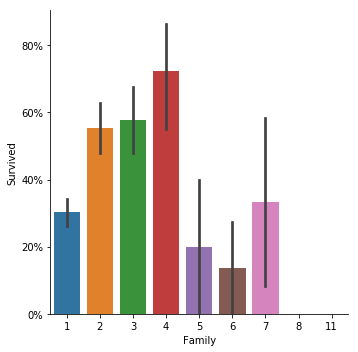

In [17]:
g = sns.catplot(x="Family", y="Survived", 
                  kind="bar", data=train)

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
    # Percentages are computed as ``x / xmax * 100``  
    
plt.show()

In [18]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived     891 non-null int64
Pclass       891 non-null int64
Sex          891 non-null int64
Age          891 non-null float64
Fare         891 non-null float64
Embarked     891 non-null object
Title        891 non-null object
CabinDeck    891 non-null object
Family       891 non-null int64
dtypes: float64(2), int64(4), object(3)
memory usage: 62.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
Pclass       418 non-null int64
Sex          418 non-null int64
Age          418 non-null float64
Fare         418 non-null float64
Embarked     418 non-null object
Title        418 non-null object
CabinDeck    418 non-null object
Family       418 non-null int64
dtypes: float64(2), int64(3), object(3)
memory usage: 26.2+ KB
None


No more missing values, can proceed with get_dummies

In [19]:
# create dummy variables for categorical feature
train_dummy = pd.get_dummies(train)
test_dummy = pd.get_dummies(test)

train_dummy.head().T

,0,1,2,3,4
Survived,0.00,1.0000,1.000,1.0,0.00
Pclass,3.00,1.0000,3.000,1.0,3.00
Sex,1.00,0.0000,0.000,0.0,1.00
Age,22.00,38.0000,26.000,35.0,35.00
Fare,7.25,71.2833,7.925,53.1,8.05
Family,2.00,2.0000,1.000,2.0,1.00
Embarked_C,0.00,1.0000,0.000,0.0,0.00
Embarked_Q,0.00,0.0000,0.000,0.0,0.00
Embarked_S,1.00,0.0000,1.000,1.0,1.00
Title_Master,0.00,0.0000,0.000,0.0,0.00


### Correlation between Features

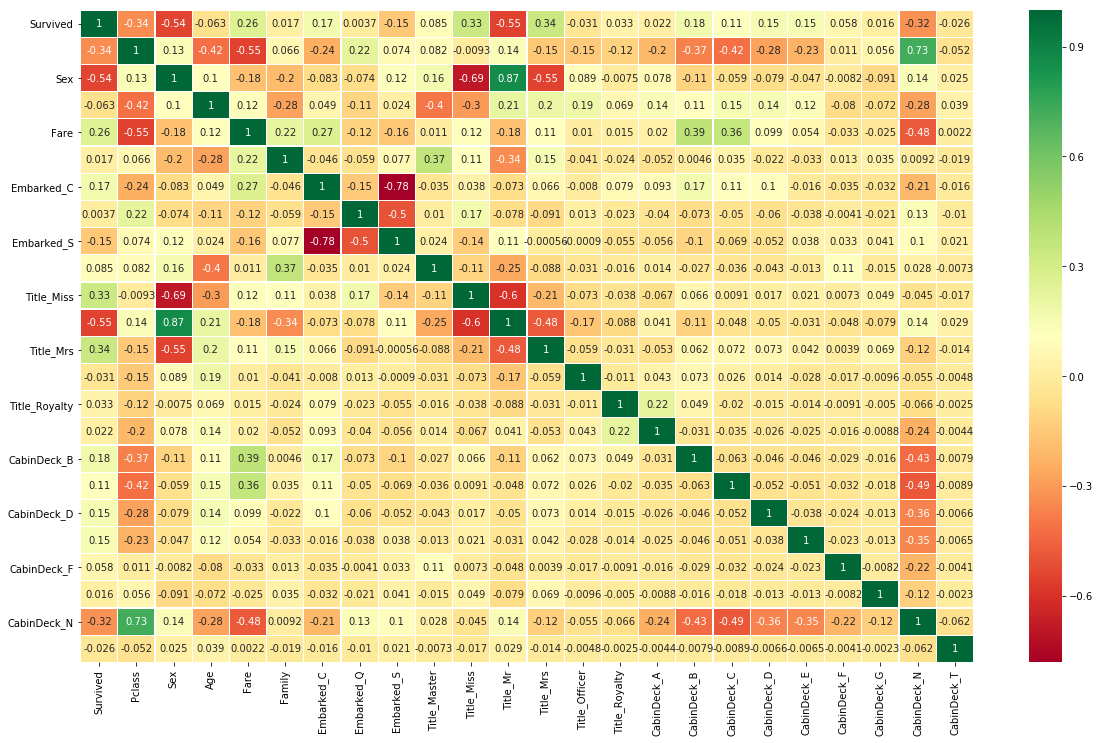

In [20]:
#data.corr()-->correlation matrix
sns.heatmap(train_dummy.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)

fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

POSITIVE CORRELATION: If an increase in feature A leads to increase in feature B, then they are positively correlated. A value 1 means perfect positive correlation.

NEGATIVE CORRELATION: If an increase in feature A leads to decrease in feature B, then they are negatively correlated. A value -1 means perfect negative correlation.

Now lets say that two features are highly or perfectly correlated, so the increase in one leads to increase in the other. This means that both the features are containing highly similar information and there is very little or no variance in information. This is known as MultiColinearity as both of them contains almost the same information.

So do you think we should use both of them as one of them is redundant. While making or training models, we should try to eliminate redundant features as it reduces training time and many such advantages.

Now from the above heatmap,we can see that the features are not much correlated. The highest correlation is between SibSp and Parch i.e 0.41. So we can carry on with all features

## Modelling

In [ ]:
Create train and test data

In [ ]:
# create X and y for data and target values 
X_train = train_dummy.drop(columns=['Survived','CabinDeck_T']) 
y_train = train_dummy['Survived']

# create array for test set
X_test = test_dummy

I drop 'CabinDeck_T' because there's only 1 value in X_train and 0 value in X_test. If not the no. of features do not match. Can create additional column in X_test by ``X_test['CabinDeck_T'] = 0 ``

In [ ]:
print(X_train.info())
print(X_test.info())

### Random Forest Classifier

In [ ]:
# create param grid object 
rf_params = dict(     
    max_depth = [n for n in range(9, 12)],     
    min_samples_split = [n for n in range(4, 10)], 
    min_samples_leaf = [n for n in range(2, 5)],     
    n_estimators = [n for n in range(10, 60, 100)])

# instantiate Random Forest model
rf= RandomForestClassifier()

# build and fit model 
grid_rf = GridSearchCV(estimator=rf, param_grid=rf_params, cv=5) 
grid_rf.fit(X_train, y_train)

print("Best score: {}".format(grid_rf.best_score_))
print("Optimal params: {}".format(grid_rf.best_estimator_))

In [ ]:
# random forrest prediction on test set
rf_pred = grid_rf.predict(X_test)

In [ ]:
from pandas import Series

# dataframe with predictions
submission = pd.DataFrame({"PassengerId": passengerId, "Survived": rf_pred})

# save to csv
submission.to_csv('titanic_pred.csv', index=False)


In [ ]:
submission = pd.read_csv("titanic_pred.csv")
submission.head()

https://www.kaggle.com/vinothan/titanic-model-with-90-accuracy